In [3]:
!ls $STORE_DIR/DL_Projects/edm_analy_traj_cmp

afhqv2_uncond_vp_edm_theory   ffhq_uncond_vp_edm_theory
cifar10_uncond_vp_edm_theory  summary


In [7]:
!cd $STORE_DIR/DL_Projects/edm_analy_traj_cmp;pwd

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/edm_analy_traj_cmp


In [ ]:
!ls $STORE_DIR/DL_Projects/edm_analy_traj_cmp/cifar10_uncond_vp_edm_theory

In [5]:
!cd $STORE_DIR; pwd

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang


In [8]:

exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/edm_analy_traj_cmp"

In [44]:
from tqdm import tqdm, trange
from os.path import join
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sys 
import re
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorization")
# import lpips
from core.utils.montage_utils import crop_all_from_montage


In [11]:
import os
dataset_dirs = os.listdir(exproot)
dataset_dirs = [d for d in dataset_dirs if not 'summary' in d]

In [12]:
dataset_dirs

['cifar10_uncond_vp_edm_theory',
 'afhqv2_uncond_vp_edm_theory',
 'ffhq_uncond_vp_edm_theory']

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lpips

Dist_vgg = lpips.LPIPS(net='vgg').cuda().eval()
Dist_alex = lpips.LPIPS(net='alex').cuda().eval()
Dist_squeeze = lpips.LPIPS(net='squeeze').cuda().eval()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4.73M/4.73M [00:00<00:00, 102MB/s]

Loading model from: /n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/lpips/weights/v0.1/squeeze.pth


In [71]:
def np_img2th_img(img_np, resolution=None):
    img_torch = torch.from_numpy(img_np.transpose(2, 0, 1)).float().cuda()
    img_torch = img_torch.unsqueeze(0)
    if resolution is not None:
        img_torch = F.interpolate(img_torch, size=resolution, mode='bilinear', align_corners=False)
    return img_torch

In [187]:
from core.utils.plot_utils import saveallforms
from core.utils.stats_utils import ttest_rel_df
from scipy.stats import ttest_rel
from itertools import combinations

def paired_strip_plot_general(df, col_names, msk=None, ax=None, errtype='sem', print_signif=True):
    if msk is None:
        msk = np.ones(len(df), dtype=bool)
    sum_tab = df[col_names].aggregate(['mean', errtype])
    n_col = len(col_names)
    vecs = [df[msk][col] for col in col_names]
    xjitter = 0.1 * np.random.randn(len(vecs[0]))
    if ax is None:
        figh = plt.figure(figsize=[5, 6])
        ax = plt.gca()
    else:
        figh = None
        plt.sca(ax)
    ax.plot(np.arange(n_col)[:,None]+xjitter[None,:],
             np.stack(vecs, axis=0), color="k", alpha=0.05)
    for i in range(n_col):
        ax.scatter(xjitter+i, vecs[i], alpha=0.3, label=col_names[i])
    ax.errorbar(np.arange(n_col), sum_tab.loc['mean'], 
                yerr=sum_tab.loc[errtype], 
                fmt='-o', color='k')
    # fill the shaded error bar
    ax.fill_between(np.arange(n_col),
                    sum_tab.loc['mean']-sum_tab.loc[errtype],
                    sum_tab.loc['mean']+sum_tab.loc[errtype],
                    color='k', alpha=0.2)
    ax.set_xticks(np.arange(n_col), col_names)
    if print_signif:
        for (i, col1), (j, col2) in combinations(enumerate(col_names), 2):
            tval, pval = ttest_rel(df[msk][col1], df[msk][col2])
            if pval < 0.01:  # Assuming a significance level of 0.05
                annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
                ax.text((i+j)/2, annot_y, '*', ha='center', va='bottom', color='red', fontsize=20)
                # add line between the two groups
                ax.plot([i, j], [annot_y, annot_y], color='red', lw=.5)
    
    # tval, pval = ttest_rel_df(df, msk, col1, col2)
    # plt.title(f"tval={tval:.3f}, pval={pval:.1e} N={msk.sum()}")
    # plt.show()
    return figh

def paired_ttest_col(df, col_names, msk=None, ax=None, errtype='sem'):
    if msk is None:
        msk = np.ones(len(df), dtype=bool)
    sum_tab = df[col_names].aggregate(['mean', errtype])
    n_col = len(col_names)
    vecs = [df[msk][col] for col in col_names]
    for i in range(n_col):
        for j in range(i+1, n_col):
            print(f"ttest {col_names[i]} vs {col_names[i-1]}")
            tval, pval = ttest_rel_df(df, msk, col_names[i], col_names[i-1])
            print(f"tval={tval:.3f}, pval={pval:.1e} N={msk.sum()}")
    # tval, pval = ttest_rel_df(df, msk, col1, col2)
    return 

In [139]:
tabdir = "/n/home12/binxuwang/Github/DiffusionMemorization/Tables"
figtabdir = join(exproot, "summary")

### Mass Compute

In [160]:
os.listdir(exproot)

['cifar10_uncond_vp_edm_theory',
 'afhqv2_uncond_vp_edm_theory',
 'ffhq_uncond_vp_edm_theory',
 'summary']

In [161]:
dataset_name = 'CIFAR10'
labels = ["EDM", "Gaussian", "GMM", "Delta"]
orig_resol = 32
dataset_dir = join(exproot, 'cifar10_uncond_vp_edm_theory')
mtg_fps = sorted(glob(join(dataset_dir, '*horz.png')))
print(len(mtg_fps))
lpips_resol = 224
stats_col = []
for mtg_i, mtg_fp in tqdm(enumerate(mtg_fps)):
    # extract RND from the filename
    match = re.findall(r'RND(\d+)_x0_cmp_horz.png', mtg_fp)
    assert len(match) == 1
    RND = int(match[0])
    mtg_np = plt.imread(mtg_fp)
    if mtg_np.shape[-1] == 4:
        mtg_np = mtg_np[..., :3]
    assert mtg_np.max() <= 1 and mtg_np.min() >= 0
    crops_np = crop_all_from_montage(mtg_np, len(labels), imgsize=orig_resol, pad=2)
    target = crops_np[0]
    target_th_norsz = np_img2th_img(target, resolution=None)
    target_th = np_img2th_img(target, resolution=lpips_resol)
    for image, label in zip(crops_np, labels):
        MSE = ((image - target) ** 2).mean()
        image_th_norsz = np_img2th_img(image, resolution=None)
        image_th = np_img2th_img(image, resolution=lpips_resol)
        with torch.no_grad():
            LPIPS_alex = Dist_alex(image_th, target_th).item()
            LPIPS_vgg = Dist_vgg(image_th, target_th).item()
            LPIPS_squeeze = Dist_squeeze(image_th, target_th).item()
            LPIPS_alex_norsz = Dist_alex(image_th_norsz, target_th_norsz).item()
            LPIPS_vgg_norsz = Dist_vgg(image_th_norsz, target_th_norsz).item()
            LPIPS_squeeze_norsz = Dist_squeeze(image_th_norsz, target_th_norsz).item()
        stats_col.append({'RND': RND, 'model': label, 'MSE': MSE, 
                          'LPIPS_alex': LPIPS_alex, 'LPIPS_vgg': LPIPS_vgg, 'LPIPS_squeeze': LPIPS_squeeze,
                          'LPIPS_alex_norsz': LPIPS_alex_norsz, 'LPIPS_vgg_norsz': LPIPS_vgg_norsz, 'LPIPS_squeeze_norsz': LPIPS_squeeze_norsz,
                          })

stats_col = pd.DataFrame(stats_col)
stats_col.to_csv(join(tabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index=False)
stats_col.to_csv(join(figtabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index=False)

512


512it [00:32, 15.84it/s]


In [162]:
dataset_name = 'AFHQv2'
labels = ["EDM", "Gaussian", "Delta"]
orig_resol = 64
dataset_dir = join(exproot, 'afhqv2_uncond_vp_edm_theory')
mtg_fps = sorted(glob(join(dataset_dir, '*horz.png')))
print(len(mtg_fps))
lpips_resol = 224
stats_col = []
for mtg_i, mtg_fp in tqdm(enumerate(mtg_fps)):
    # extract RND from the filename
    match = re.findall(r'RND(\d+)_x0_cmp_horz.png', mtg_fp)
    assert len(match) == 1
    RND = int(match[0])
    mtg_np = plt.imread(mtg_fp)
    if mtg_np.shape[-1] == 4:
        mtg_np = mtg_np[..., :3]
    assert mtg_np.max() <= 1 and mtg_np.min() >= 0
    crops_np = crop_all_from_montage(mtg_np, len(labels), imgsize=orig_resol, pad=2)
    target = crops_np[0]
    target_th_norsz = np_img2th_img(target, resolution=None)
    target_th = np_img2th_img(target, resolution=lpips_resol)
    for image, label in zip(crops_np, labels):
        MSE = ((image - target) ** 2).mean()
        image_th_norsz = np_img2th_img(image, resolution=None)
        image_th = np_img2th_img(image, resolution=lpips_resol)
        with torch.no_grad():
            LPIPS_alex = Dist_alex(image_th, target_th).item()
            LPIPS_vgg = Dist_vgg(image_th, target_th).item()
            LPIPS_squeeze = Dist_squeeze(image_th, target_th).item()
            LPIPS_alex_norsz = Dist_alex(image_th_norsz, target_th_norsz).item()
            LPIPS_vgg_norsz = Dist_vgg(image_th_norsz, target_th_norsz).item()
            LPIPS_squeeze_norsz = Dist_squeeze(image_th_norsz, target_th_norsz).item()
        stats_col.append({'RND': RND, 'model': label, 'MSE': MSE, 
                          'LPIPS_alex': LPIPS_alex, 'LPIPS_vgg': LPIPS_vgg, 'LPIPS_squeeze': LPIPS_squeeze,
                          'LPIPS_alex_norsz': LPIPS_alex_norsz, 'LPIPS_vgg_norsz': LPIPS_vgg_norsz, 'LPIPS_squeeze_norsz': LPIPS_squeeze_norsz,
                          })

stats_col = pd.DataFrame(stats_col)
stats_col.to_csv(join(tabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index=False)
stats_col.to_csv(join(figtabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index=False)


512


0it [00:00, ?it/s]

512it [00:24, 20.51it/s]


In [163]:
dataset_name = 'FFHQ'
labels = ["EDM", "Gaussian", "Delta"]
orig_resol = 64
dataset_dir = join(exproot, 'ffhq_uncond_vp_edm_theory')
mtg_fps = sorted(glob(join(dataset_dir, '*horz.png')))
print(len(mtg_fps))
lpips_resol = 224
stats_col = []
for mtg_i, mtg_fp in tqdm(enumerate(mtg_fps)):
    # extract RND from the filename
    match = re.findall(r'RND(\d+)_x0_cmp_horz.png', mtg_fp)
    assert len(match) == 1
    RND = int(match[0])
    mtg_np = plt.imread(mtg_fp)
    if mtg_np.shape[-1] == 4:
        mtg_np = mtg_np[..., :3]
    assert mtg_np.max() <= 1
    assert mtg_np.min() >= 0
    crops_np = crop_all_from_montage(mtg_np, len(labels), imgsize=orig_resol, pad=2)
    target = crops_np[0]
    target_th_norsz = np_img2th_img(target, resolution=None)
    target_th = np_img2th_img(target, resolution=lpips_resol)
    for image, label in zip(crops_np, labels):
        MSE = ((image - target) ** 2).mean()
        image_th_norsz = np_img2th_img(image, resolution=None)
        image_th = np_img2th_img(image, resolution=lpips_resol)
        with torch.no_grad():
            LPIPS_alex = Dist_alex(image_th, target_th).item()
            LPIPS_vgg = Dist_vgg(image_th, target_th).item()
            LPIPS_squeeze = Dist_squeeze(image_th, target_th).item()
            LPIPS_alex_norsz = Dist_alex(image_th_norsz, target_th_norsz).item()
            LPIPS_vgg_norsz = Dist_vgg(image_th_norsz, target_th_norsz).item()
            LPIPS_squeeze_norsz = Dist_squeeze(image_th_norsz, target_th_norsz).item()
        stats_col.append({'RND': RND, 'model': label, 'MSE': MSE, 
                          'LPIPS_alex': LPIPS_alex, 'LPIPS_vgg': LPIPS_vgg, 'LPIPS_squeeze': LPIPS_squeeze,
                          'LPIPS_alex_norsz': LPIPS_alex_norsz, 'LPIPS_vgg_norsz': LPIPS_vgg_norsz, 'LPIPS_squeeze_norsz': LPIPS_squeeze_norsz,
                          })

stats_col = pd.DataFrame(stats_col)
stats_col.to_csv(join(tabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index=False)
stats_col.to_csv(join(figtabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index=False)

256


0it [00:00, ?it/s]

256it [00:12, 20.43it/s]


### CIFAR10

In [192]:
dataset_name = 'CIFAR10'
labels = ["EDM", "Gaussian", "GMM", "Delta"]
stats_col = pd.read_csv(join(tabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index_col=None)

In [193]:
print(dataset_name)
for i, metric in enumerate(['MSE', 'LPIPS_alex', 'LPIPS_vgg', 'LPIPS_squeeze']):
    stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
    print(metric, "=====================")
    paired_ttest_col(stats_col_pivot, ['Gaussian', 'GMM', 'Delta'], )

CIFAR10
MSE =====================
ttest Gaussian vs Delta
tval=-45.266, pval=6.2e-181 N=512
ttest Gaussian vs Delta
tval=-45.266, pval=6.2e-181 N=512
ttest GMM vs Gaussian
tval=-12.888, pval=4.1e-33 N=512
LPIPS_alex =====================
ttest Gaussian vs Delta
tval=-20.309, pval=1.1e-67 N=512
ttest Gaussian vs Delta
tval=-20.309, pval=1.1e-67 N=512
ttest GMM vs Gaussian
tval=-12.116, pval=7.1e-30 N=512
LPIPS_vgg =====================
ttest Gaussian vs Delta
tval=-25.392, pval=1.3e-92 N=512
ttest Gaussian vs Delta
tval=-25.392, pval=1.3e-92 N=512
ttest GMM vs Gaussian
tval=-5.455, pval=7.7e-08 N=512
LPIPS_squeeze =====================
ttest Gaussian vs Delta
tval=-17.211, pval=1.1e-52 N=512
ttest Gaussian vs Delta
tval=-17.211, pval=1.1e-52 N=512
ttest GMM vs Gaussian
tval=-10.492, pval=1.9e-23 N=512


/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann

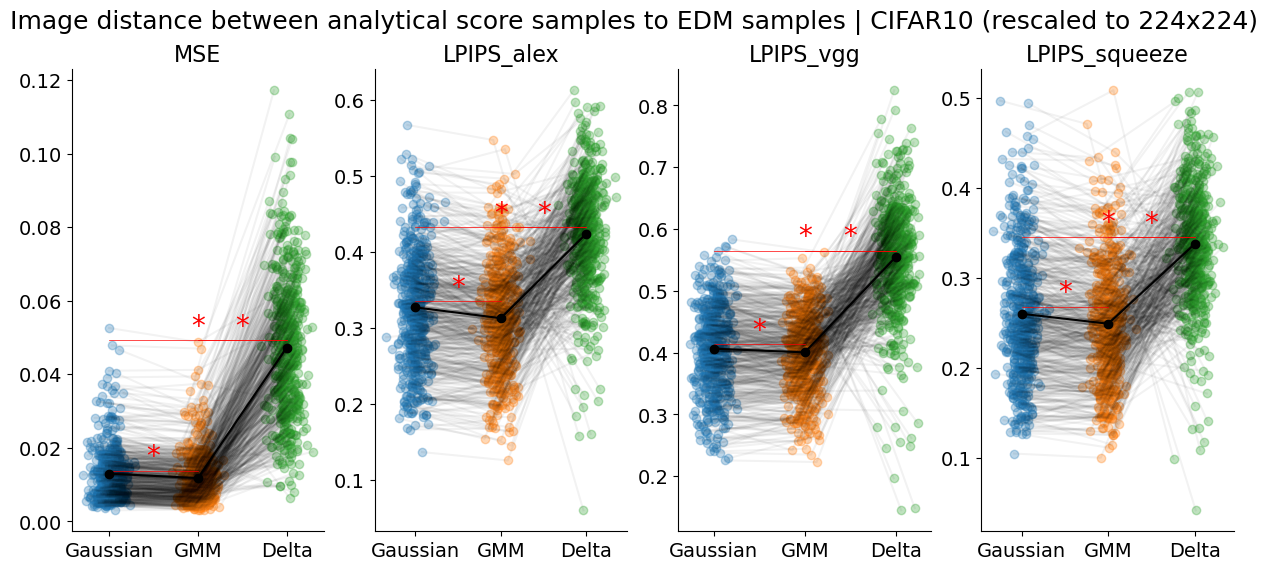

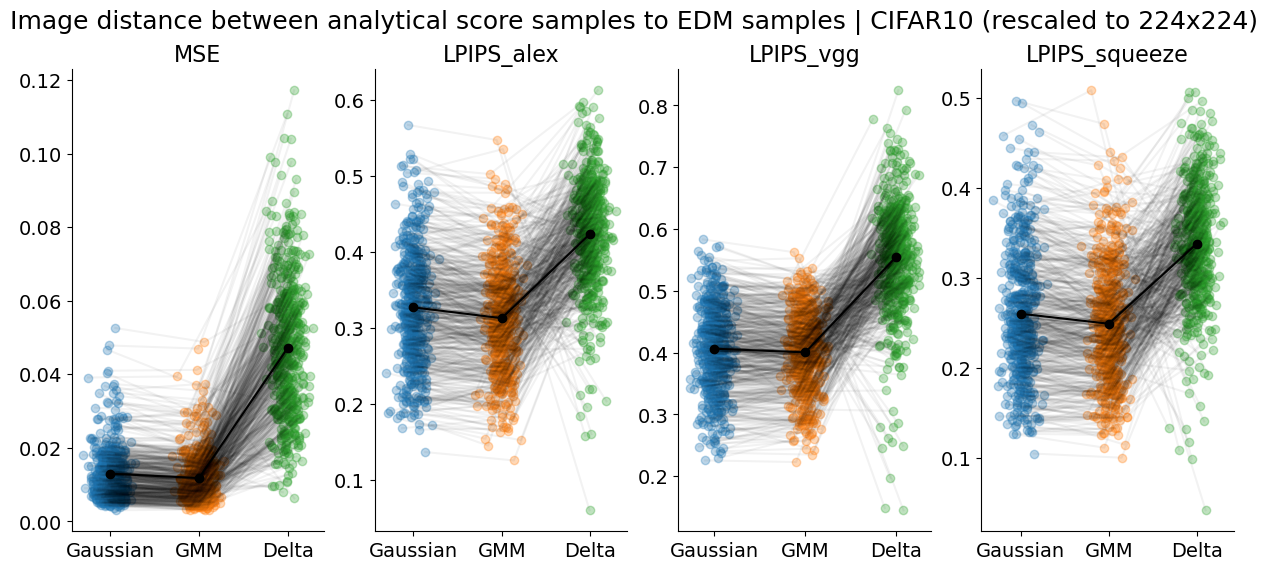

In [194]:
for print_signif in [True, False]:

    figh, axs = plt.subplots(1, 4, figsize=(15, 6))
    for i, metric in enumerate(['MSE', 'LPIPS_alex', 'LPIPS_vgg', 'LPIPS_squeeze']):
        stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
        paired_strip_plot_general(stats_col_pivot, ['Gaussian', 'GMM', 'Delta'], msk=None, ax=axs[i], errtype='sem',
                                  print_signif=print_signif)
        axs[i].set_title(metric, fontsize=16)
        axs[i].set_xticklabels(['Gaussian', 'GMM', 'Delta'], fontsize=14)
        axs[i].tick_params(axis='both', labelsize=14)
        
    plt.suptitle(f"Image distance between analytical score samples to EDM samples | {dataset_name} (rescaled to 224x224)",
                fontsize=18)
    # saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips", figh, fmts=['png', 'pdf'])
    saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips{'_signif' if print_signif else ''}", figh, fmts=['png', 'pdf'])
    plt.show()

In [195]:
print(dataset_name)
for i, metric in enumerate(['MSE', 'LPIPS_alex_norsz', 'LPIPS_vgg_norsz', 'LPIPS_squeeze_norsz']):
    stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
    print(metric, "=====================")
    paired_ttest_col(stats_col_pivot, ['Gaussian', 'GMM', 'Delta'], )

CIFAR10
MSE =====================
ttest Gaussian vs Delta
tval=-45.266, pval=6.2e-181 N=512
ttest Gaussian vs Delta
tval=-45.266, pval=6.2e-181 N=512
ttest GMM vs Gaussian
tval=-12.888, pval=4.1e-33 N=512
LPIPS_alex_norsz =====================
ttest Gaussian vs Delta
tval=-17.197, pval=1.3e-52 N=512
ttest Gaussian vs Delta
tval=-17.197, pval=1.3e-52 N=512
ttest GMM vs Gaussian
tval=-13.406, pval=2.5e-35 N=512
LPIPS_vgg_norsz =====================
ttest Gaussian vs Delta
tval=-16.442, pval=4.6e-49 N=512
ttest Gaussian vs Delta
tval=-16.442, pval=4.6e-49 N=512
ttest GMM vs Gaussian
tval=-12.265, pval=1.7e-30 N=512
LPIPS_squeeze_norsz =====================
ttest Gaussian vs Delta
tval=12.437, pval=3.3e-31 N=512
ttest Gaussian vs Delta
tval=12.437, pval=3.3e-31 N=512
ttest GMM vs Gaussian
tval=-15.649, pval=2.2e-45 N=512


/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()


/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()


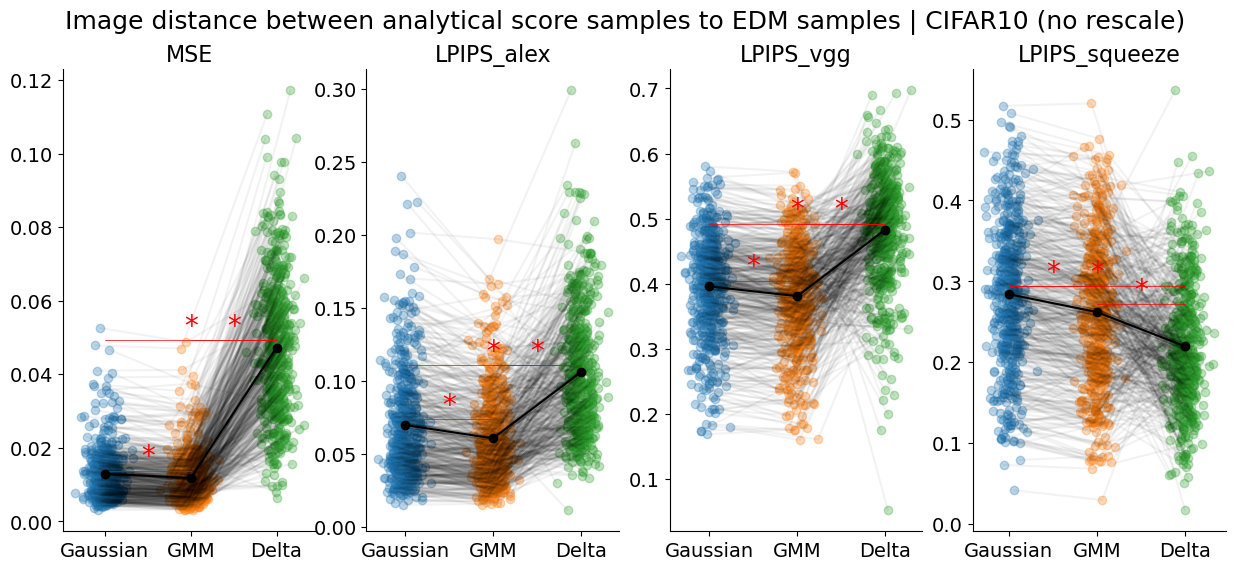

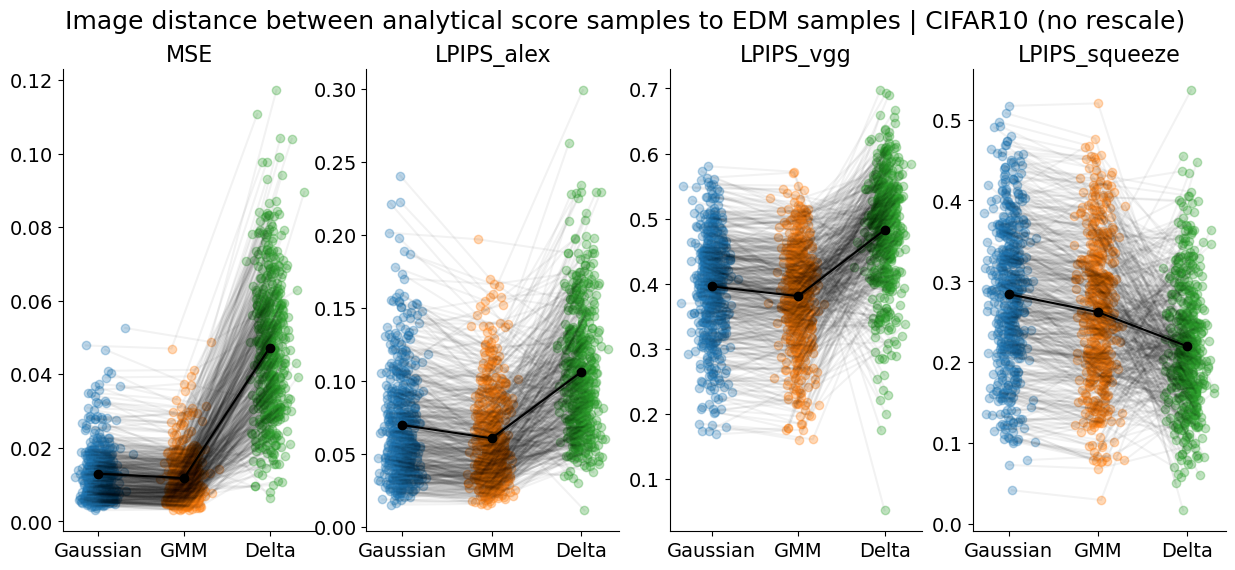

In [196]:
for print_signif in [True, False]:
    figh, axs = plt.subplots(1, 4, figsize=(15, 6))
    for i, metric in enumerate(['MSE', 'LPIPS_alex_norsz', 'LPIPS_vgg_norsz', 'LPIPS_squeeze_norsz']):
        stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
        paired_strip_plot_general(stats_col_pivot, ['Gaussian', 'GMM', 'Delta'], msk=None, ax=axs[i], errtype='sem',
                                  print_signif=print_signif)
        axs[i].set_title(metric.replace("_norsz",""), fontsize=16)
        axs[i].set_xticklabels(['Gaussian', 'GMM', 'Delta'], fontsize=14)
        axs[i].tick_params(axis='both', labelsize=14)
        
    plt.suptitle(f"Image distance between analytical score samples to EDM samples | {dataset_name} (no rescale)",
                fontsize=18)
    # saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips_norsz", figh, fmts=['png', 'pdf'])
    saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips_norsz{'_signif' if print_signif else ''}", figh, fmts=['png', 'pdf'])
    plt.show()

### AFHQ

In [207]:
dataset_name = 'AFHQv2'
labels = ["EDM", "Gaussian", "Delta"]
stats_col = pd.read_csv(join(tabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index_col=None)

In [208]:
print(dataset_name)
for i, metric in enumerate(['MSE', 'LPIPS_alex', 'LPIPS_vgg', 'LPIPS_squeeze']):
    stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
    print(metric, "=====================")
    paired_ttest_col(stats_col_pivot, ['Gaussian', 'Delta'], )

AFHQv2
MSE =====================
ttest Gaussian vs Delta
tval=-58.661, pval=3.9e-229 N=512
LPIPS_alex =====================
ttest Gaussian vs Delta
tval=-0.296, pval=7.7e-01 N=512
LPIPS_vgg =====================
ttest Gaussian vs Delta
tval=-29.808, pval=7.1e-114 N=512
LPIPS_squeeze =====================
ttest Gaussian vs Delta
tval=-10.785, pval=1.4e-24 N=512


/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann

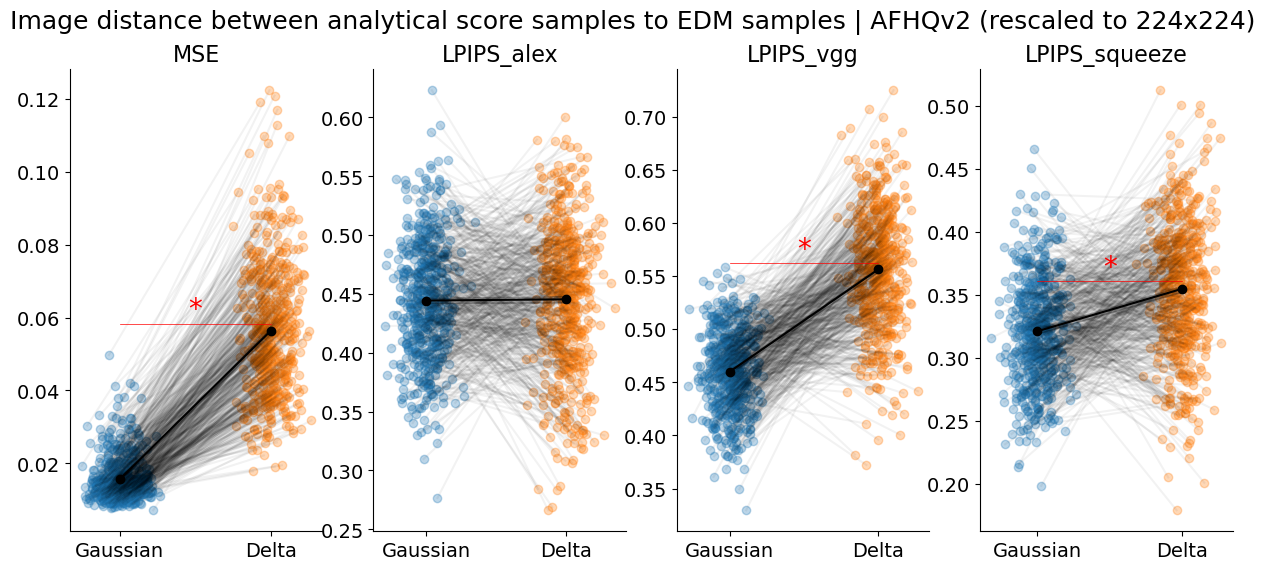

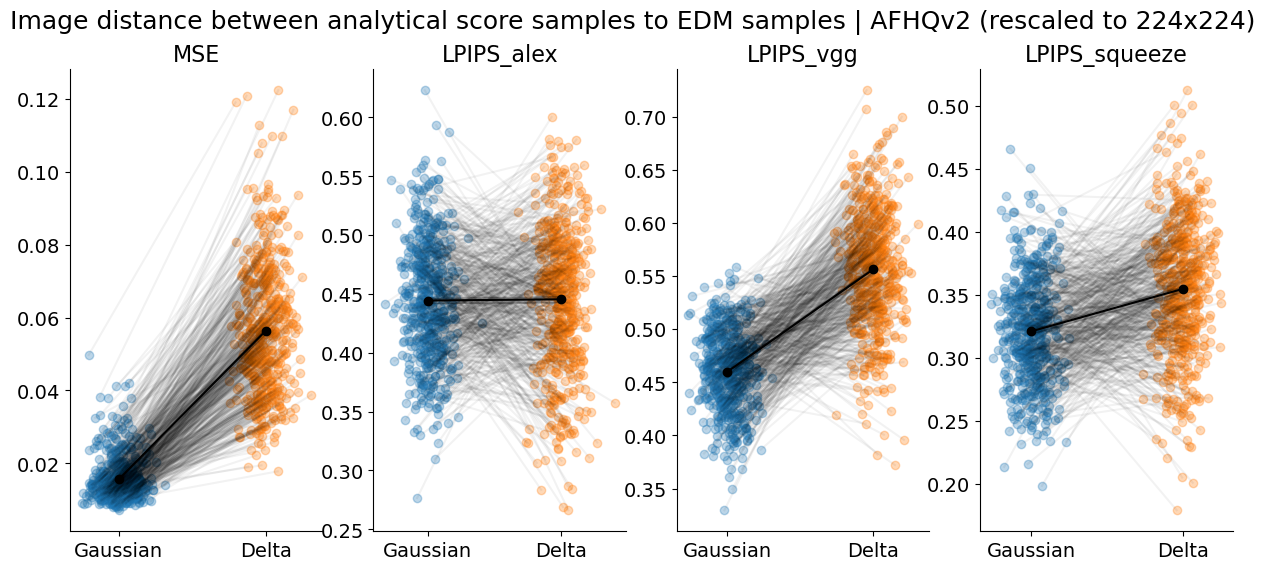

In [209]:
for print_signif in [True, False]:
    figh, axs = plt.subplots(1, 4, figsize=(15, 6))
    for i, metric in enumerate(['MSE', 'LPIPS_alex', 'LPIPS_vgg', 'LPIPS_squeeze']):
        stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
        paired_strip_plot_general(stats_col_pivot, ['Gaussian', 'Delta'], msk=None, ax=axs[i], 
                                errtype='sem', print_signif=print_signif)
        axs[i].set_title(metric, fontsize=16)
        axs[i].set_xticklabels(['Gaussian', 'Delta'], fontsize=14)
        axs[i].tick_params(axis='both', labelsize=14)
        
    plt.suptitle(f"Image distance between analytical score samples to EDM samples | {dataset_name} (rescaled to 224x224)",
                fontsize=18)
    saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips{'_signif' if print_signif else ''}", figh, fmts=['png', 'pdf'])
    plt.show()

In [210]:
print(dataset_name)
for i, metric in enumerate(['MSE', 'LPIPS_alex_norsz', 'LPIPS_vgg_norsz', 'LPIPS_squeeze_norsz']):
    stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
    print(metric, "=====================")
    paired_ttest_col(stats_col_pivot, ['Gaussian', 'Delta'], )

AFHQv2
MSE =====================
ttest Gaussian vs Delta
tval=-58.661, pval=3.9e-229 N=512
LPIPS_alex_norsz =====================
ttest Gaussian vs Delta
tval=9.971, pval=1.6e-21 N=512
LPIPS_vgg_norsz =====================
ttest Gaussian vs Delta
tval=-4.648, pval=4.3e-06 N=512
LPIPS_squeeze_norsz =====================
ttest Gaussian vs Delta
tval=26.474, pval=7.0e-98 N=512


/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann

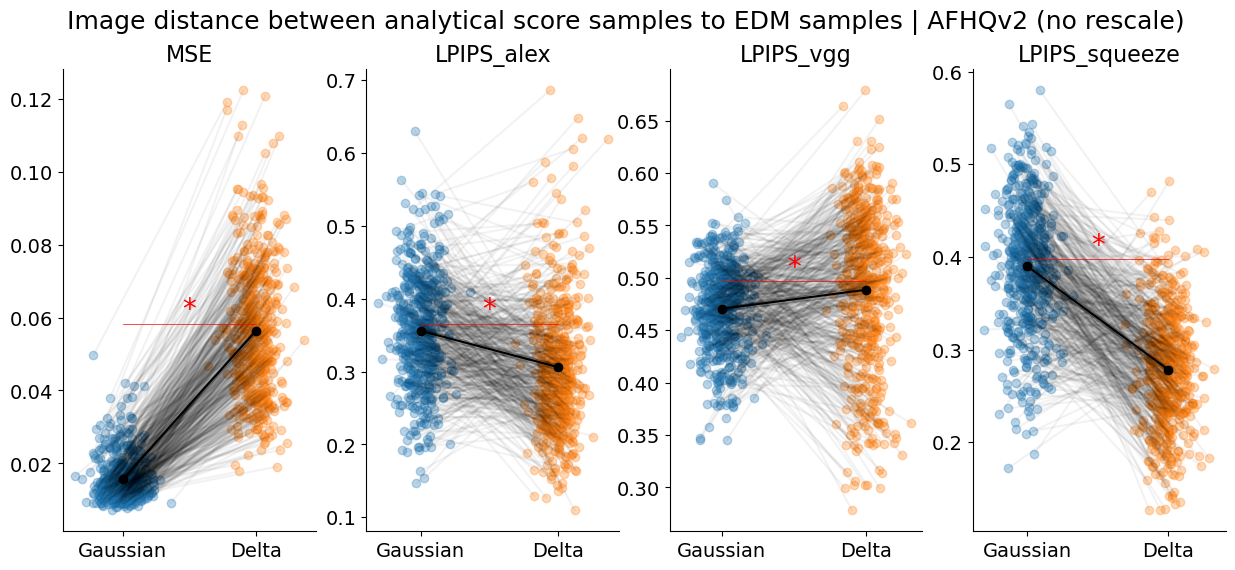

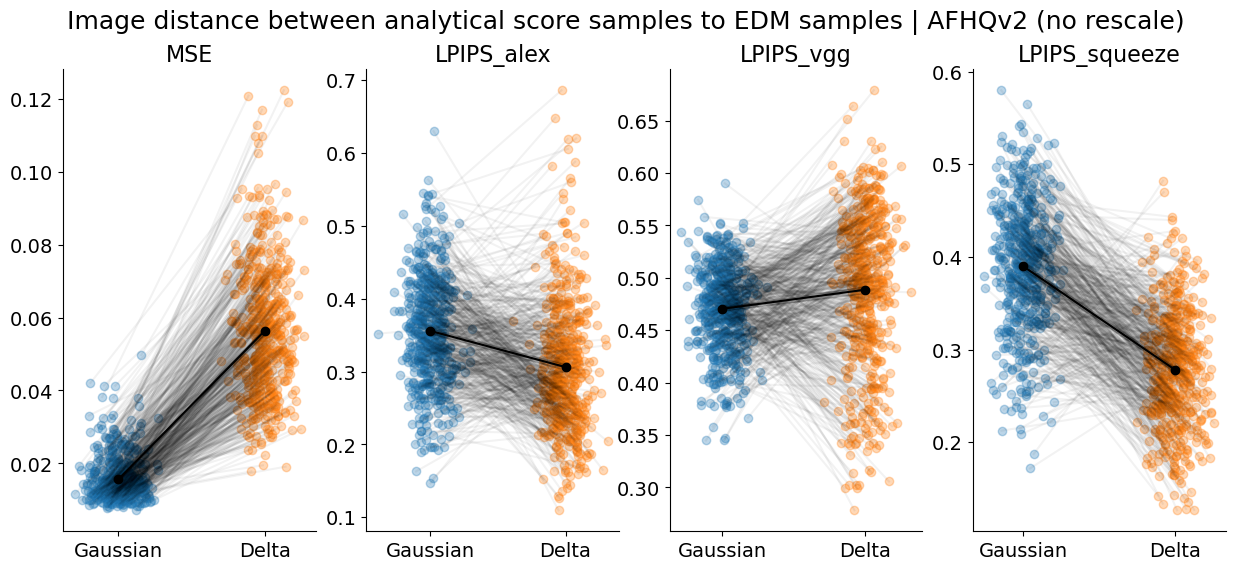

In [211]:
for print_signif in [True, False]:
    figh, axs = plt.subplots(1, 4, figsize=(15, 6))
    for i, metric in enumerate(['MSE', 'LPIPS_alex_norsz', 'LPIPS_vgg_norsz', 'LPIPS_squeeze_norsz']):
        stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
        paired_strip_plot_general(stats_col_pivot, ['Gaussian', 'Delta'], msk=None, ax=axs[i], errtype='sem', 
                                  print_signif=print_signif)
        axs[i].set_title(metric.replace("_norsz",""), fontsize=16)
        axs[i].set_xticklabels(['Gaussian', 'Delta'], fontsize=14)
        axs[i].tick_params(axis='both', labelsize=14)
        
    plt.suptitle(f"Image distance between analytical score samples to EDM samples | {dataset_name} (no rescale)",
                fontsize=18)
    saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips_norsz{'_signif' if print_signif else ''}", figh, fmts=['png', 'pdf'])
    plt.show()

### FFHQ 

In [202]:
dataset_name = 'FFHQ'
labels = ["EDM", "Gaussian", "Delta"]
stats_col = pd.read_csv(join(tabdir, f"{dataset_name}_EDM_GMM_sample_cmp_lpips.csv"), index_col=None)

In [203]:
print(dataset_name)
for i, metric in enumerate(['MSE', 'LPIPS_alex', 'LPIPS_vgg', 'LPIPS_squeeze']):
    stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
    print(metric, "=====================")
    paired_ttest_col(stats_col_pivot, ['Gaussian', 'Delta'], )

FFHQ
MSE =====================
ttest Gaussian vs Delta
tval=-36.783, pval=5.9e-104 N=256
LPIPS_alex =====================
ttest Gaussian vs Delta
tval=-3.647, pval=3.2e-04 N=256
LPIPS_vgg =====================
ttest Gaussian vs Delta
tval=-15.455, pval=1.8e-38 N=256
LPIPS_squeeze =====================
ttest Gaussian vs Delta
tval=-4.234, pval=3.2e-05 N=256


/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann

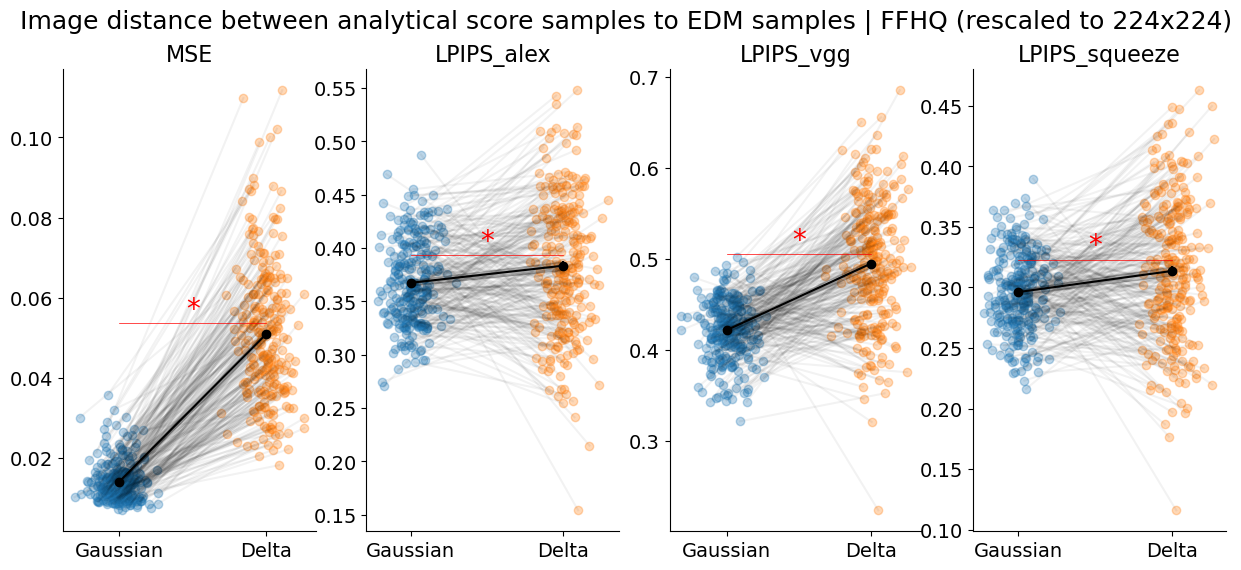

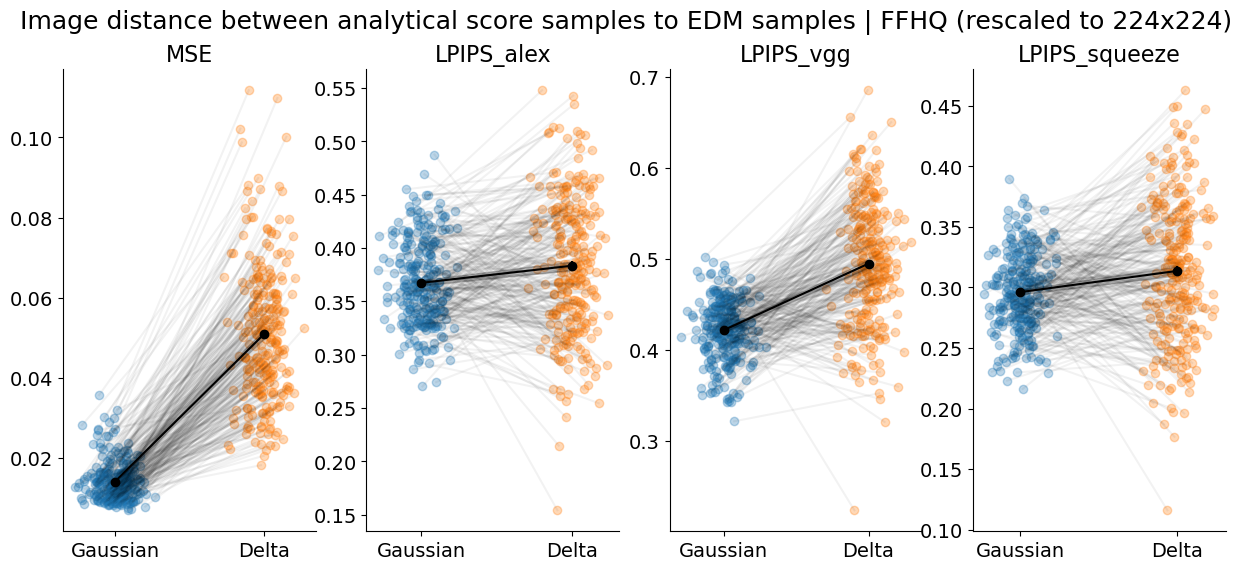

In [204]:
for print_signif in [True, False]:
    figh, axs = plt.subplots(1, 4, figsize=(15, 6))
    for i, metric in enumerate(['MSE', 'LPIPS_alex', 'LPIPS_vgg', 'LPIPS_squeeze']):
        stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
        paired_strip_plot_general(stats_col_pivot, ['Gaussian', 'Delta'], msk=None, ax=axs[i], errtype='sem',
                                print_signif=print_signif)
        axs[i].set_title(metric, fontsize=16)
        axs[i].set_xticklabels(['Gaussian', 'Delta'], fontsize=14)
        axs[i].tick_params(axis='both', labelsize=14)
        
    plt.suptitle(f"Image distance between analytical score samples to EDM samples | {dataset_name} (rescaled to 224x224)",
                fontsize=18)
    saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips{'_signif' if print_signif else ''}", figh, fmts=['png', 'pdf'])
    plt.show()

In [205]:
print(dataset_name)
for i, metric in enumerate(['MSE', 'LPIPS_alex_norsz', 'LPIPS_vgg_norsz', 'LPIPS_squeeze_norsz']):
    stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
    print(metric, "=====================")
    paired_ttest_col(stats_col_pivot, ['Gaussian', 'Delta'], )

FFHQ
MSE =====================
ttest Gaussian vs Delta
tval=-36.783, pval=5.9e-104 N=256
LPIPS_alex_norsz =====================
ttest Gaussian vs Delta
tval=0.868, pval=3.9e-01 N=256
LPIPS_vgg_norsz =====================
ttest Gaussian vs Delta
tval=-0.212, pval=8.3e-01 N=256
LPIPS_squeeze_norsz =====================
ttest Gaussian vs Delta
tval=22.479, pval=2.0e-62 N=256


/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()
/tmp/ipykernel_1806250/2910685554.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annot_y = max(sum_tab.loc['mean'][[i, j]]) + 2.5 * sum_tab.loc[errtype][[i, j]].max()


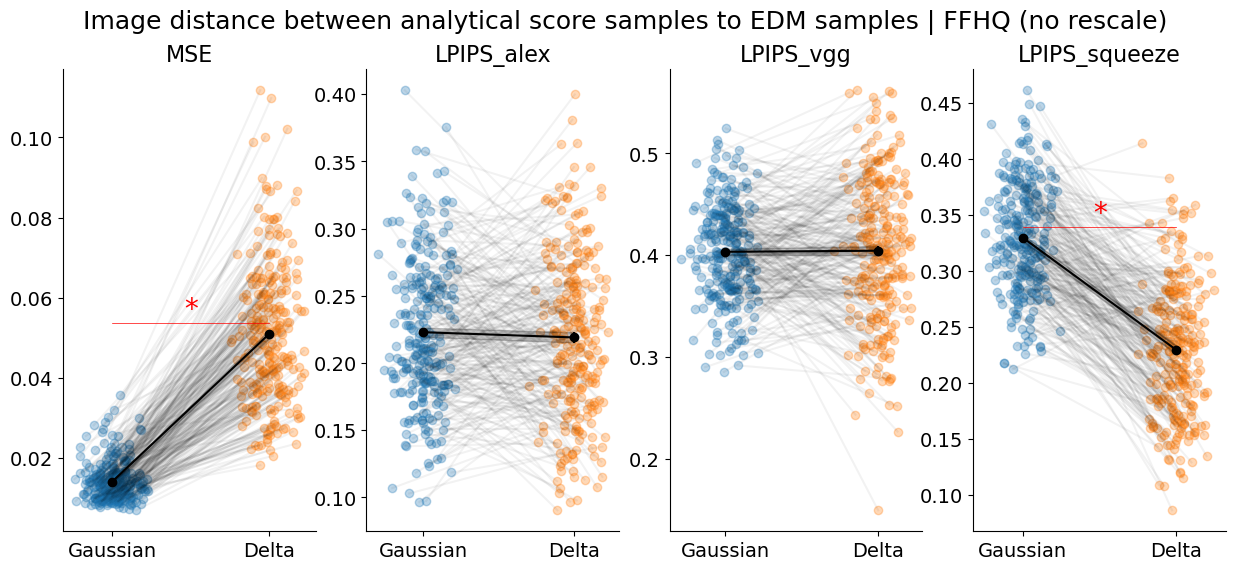

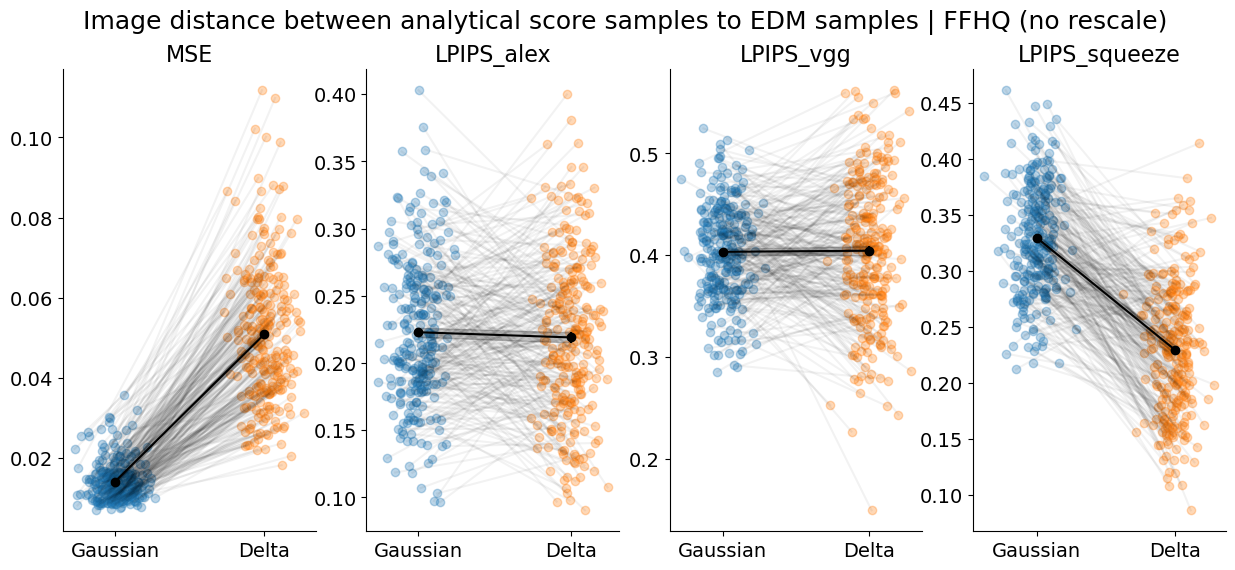

In [206]:
for print_signif in [True, False]:
    figh, axs = plt.subplots(1, 4, figsize=(15, 6))
    for i, metric in enumerate(['MSE', 'LPIPS_alex_norsz', 'LPIPS_vgg_norsz', 'LPIPS_squeeze_norsz']):
        stats_col_pivot = stats_col.pivot(index='RND', columns='model', values=metric)
        paired_strip_plot_general(stats_col_pivot, ['Gaussian', 'Delta'], msk=None, ax=axs[i], errtype='sem',
                                print_signif=print_signif)
        axs[i].set_title(metric.replace("_norsz",""), fontsize=16)
        axs[i].set_xticklabels(['Gaussian', 'Delta'], fontsize=14)
        axs[i].tick_params(axis='both', labelsize=14)
        
    plt.suptitle(f"Image distance between analytical score samples to EDM samples | {dataset_name} (no rescale)",
                fontsize=18)
    saveallforms([figtabdir], f"{dataset_name}_EDM_GMM_sample_cmp_lpips_norsz{'_signif' if print_signif else ''}", figh, fmts=['png', 'pdf'])
    plt.show()

### Scratch zone

In [213]:
exproot

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/edm_analy_traj_cmp'

After rescaling to 224x224, the LPIPS scores are:


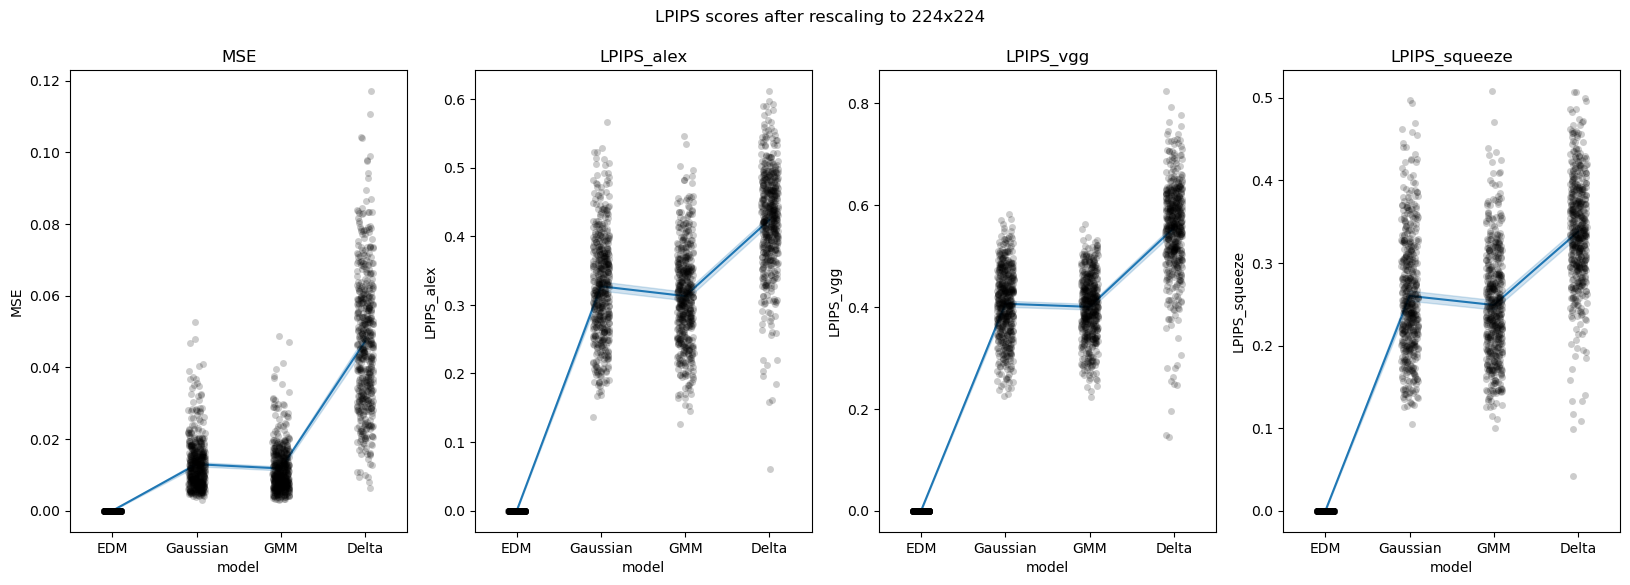

In [ ]:
print("After rescaling to 224x224, the LPIPS scores are:")
figh, axs = plt.subplots(1, 4, figsize=(20, 6))
for i, metric in enumerate(['MSE', 'LPIPS_alex', 'LPIPS_vgg', 'LPIPS_squeeze', ]):
    sns.lineplot(data=stats_col, x='model', y=metric, ax=axs[i])
    sns.stripplot(data=stats_col, x='model', y=metric, ax=axs[i], color='black', alpha=0.2)
    axs[i].set_title(metric)
plt.suptitle("LPIPS scores (rescaled to 224x224)")
plt.show()

Before rescaling to 224x224, the LPIPS scores are:
There seems to be some artifacts in the LPIPS scores, especially for the LPIPS squeeze.


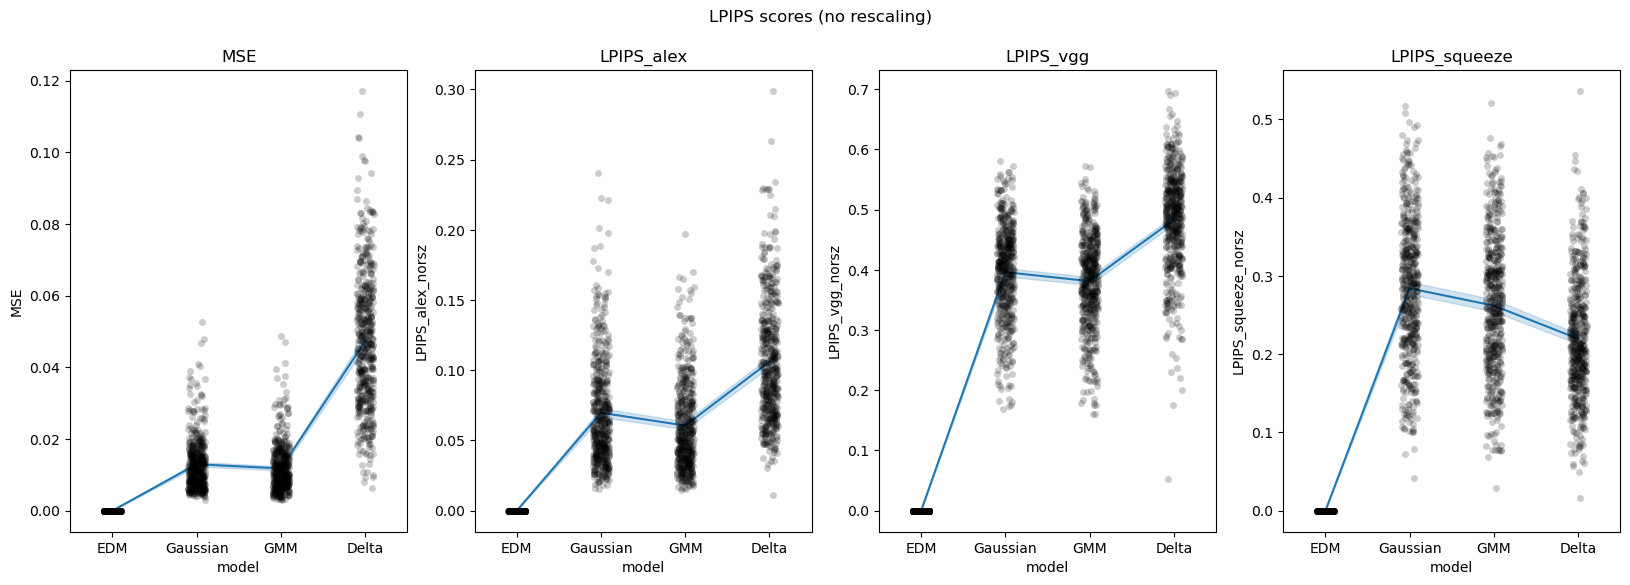

In [ ]:
print("Before rescaling to 224x224, the LPIPS scores are:")
print("There seems to be some artifacts in the LPIPS scores, especially for the LPIPS squeeze.")
figh, axs = plt.subplots(1, 4, figsize=(20, 6))
for i, metric in enumerate(['MSE', 'LPIPS_alex_norsz', 'LPIPS_vgg_norsz', 'LPIPS_squeeze_norsz', ]):
    sns.lineplot(data=stats_col, x='model', y=metric, ax=axs[i])
    sns.stripplot(data=stats_col, x='model', y=metric, ax=axs[i], color='black', alpha=0.2)
    axs[i].set_title(metric.replace('_norsz', ''))
plt.suptitle("LPIPS scores (no rescaling)")
plt.show()
    

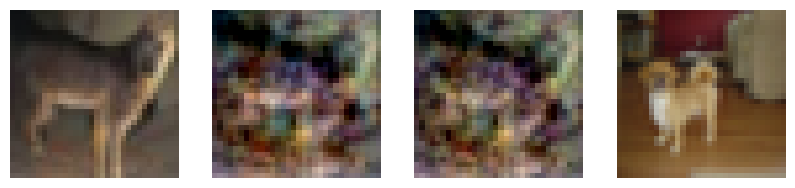

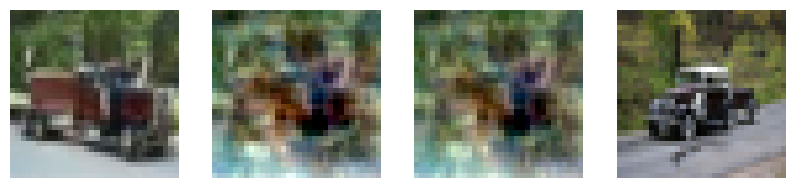

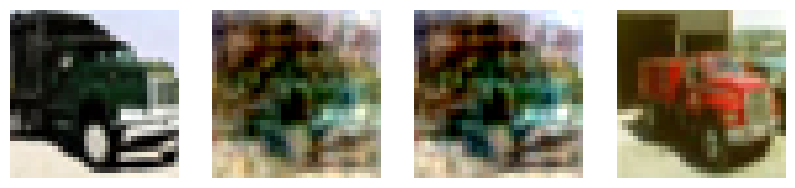

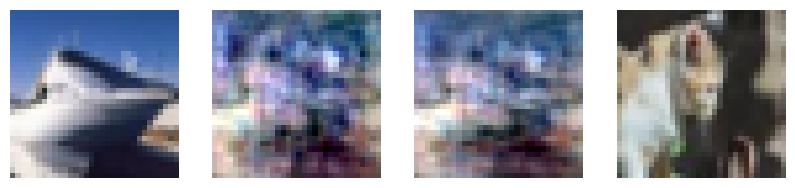

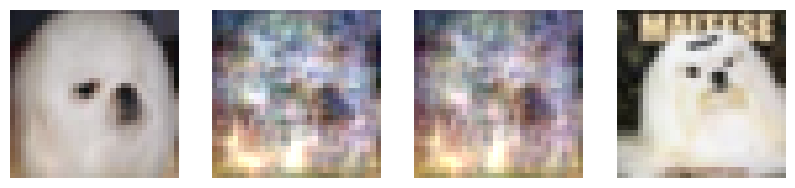

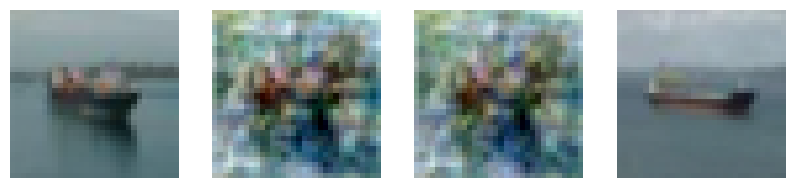

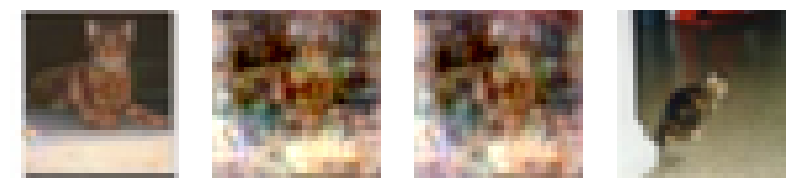

In [ ]:
# Demo images
for mtg_i, mtg_fp in enumerate(mtg_fps):
    mtg_np = plt.imread(mtg_fp)
    if mtg_np.shape[-1] == 4:
        mtg_np = mtg_np[..., :3]
    crops_np = crop_all_from_montage(mtg_np, 4, imgsize=32, pad=2)
    # imshow all the crops
    fig, ax = plt.subplots(1, 4, figsize=(10, 3))
    for i in range(4):
        ax[i].imshow(crops_np[i])
        ax[i].axis('off')
    plt.show()
    if mtg_i > 5:
        break